# Lab 4

Mikhail working notes

### Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras

keras.utils.set_random_seed(812)

note for below:

y_train and y_test are not used in the notebook?


In [2]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

(train_data, train_labels), (test_data, test_labels) = keras.datasets.reuters.load_data(num_words = 10000)

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Shape from 8982, to  to 8982,46
one_hot_train_labels = keras.utils.to_categorical(train_labels)
one_hot_test_labels = keras.utils.to_categorical(test_labels)

partial_x_train=x_train[1000:]
partial_y_train=one_hot_train_labels[1000:]
x_val=x_train[:1000]
y_val=one_hot_train_labels[:1000]

In [3]:
model = keras.models.Sequential()
model.add(keras.Input((10000,)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(46, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Data

A data point is an article, encoded as an erray, where each element is a word index. Words are indexed by frequency, so 1 is the most common word.

A label is a topic.

In [4]:
mapping = keras.datasets.reuters.get_word_index(path="reuters_word_index.json")
print(f"'The' has index: {mapping['the']}")

reverse_mapping = {value + 3: key for key, value in mapping.items()}
print(f"The fourth most common word is: {reverse_mapping[5]}")

article = [reverse_mapping.get(word_index, '?') for word_index in train_data[0]]

print(" ".join(article))


'The' has index: 1
The fourth most common word is: of
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### Baseline

This is classification, so our first guess is $\frac{1}{classes}$.

In [5]:
# Show number of classes
print(f"Classes: {y_val.shape[1]}")

correct = (np.random.randint(0, 46, size=len(test_labels)) == test_labels).sum()
print(f"Baseline random: {correct / len(test_labels)}")



Classes: 46
Baseline random: 0.023597506678539625


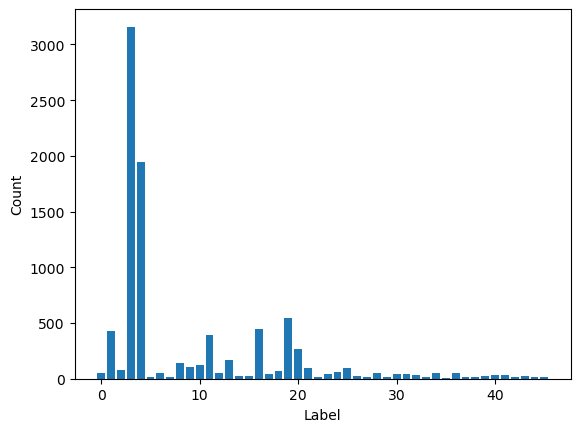

In [6]:
# Look at data set for balance
plt.bar(*np.unique(train_labels, return_counts=True))
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


Since the data set is imbalanced, we guess the the most common class instead.

In [7]:
# Get the most common
labels, counts = np.unique(train_labels, return_counts = True)
most_frequent = labels[counts.argmax()]
print(f"most frequent label: {most_frequent}")

correct = (np.full(len(test_labels), 3) == test_labels).sum()
print(f"Baseline most common: {correct / len(test_labels)}")


most frequent label: 3
Baseline most common: 0.3619768477292965


**Sanity check**

In [8]:
loss, accuracy = model.evaluate(partial_x_train, partial_y_train, verbose=0)
print(f"baseline loss: {loss}, baseline accuracy: {accuracy}")

baseline loss: 3.843754291534424, baseline accuracy: 0.005888248328119516


This is not what I would expect. I would expect the untrained model to be about as good as random (~2.0% accuracy), but this has 0.5% accuracy.

Why is this?

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


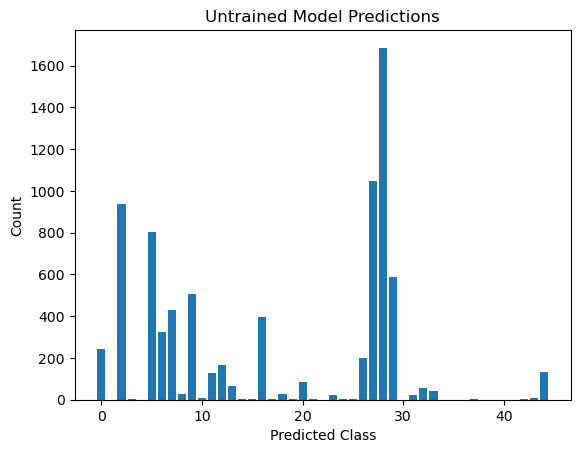

In [9]:
preds = model.predict(partial_x_train).argmax(axis=1)
labels, counts = np.unique(preds, return_counts=True)

plt.bar(labels, counts)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Untrained Model Predictions')
plt.show()

In [10]:
def softmax(x):
    e = np.exp(x)
    return e / e.sum()

logits = np.array([1.01, 1.02, 0.99])
softmaxed = softmax(logits)

print(softmaxed)

[0.33442033 0.33778131 0.32779836]


It turns out it is because an untrained model does not produce an even distribution.

An untrained model has random weights/biases (small numbers), so it is cutting up space in lots of random ways.

If we give it an input set, it cuts it up, somewhat randomly, *but with small uneveness.*

But then the output logits are softmaxed, which makes the small uneveness in the cuts super amplified, so we get very unbalanced distribution.

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


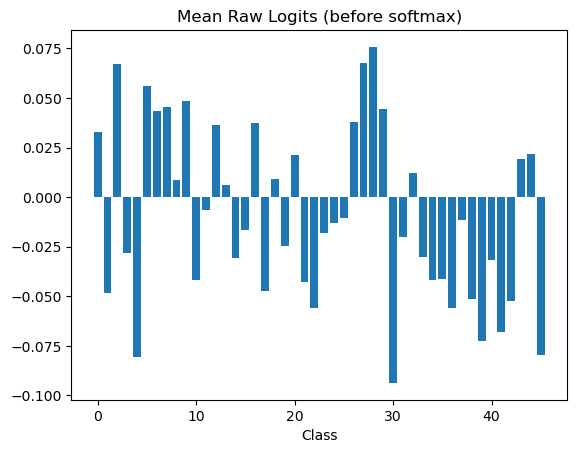

In [11]:
def show_logits():
    model_linear = keras.models.Sequential()
    model_linear.add(keras.Input((10000,)))
    model_linear.add(keras.layers.Dense(64, activation='relu'))
    model_linear.add(keras.layers.Dense(64, activation='relu'))
    model_linear.add(keras.layers.Dense(46, activation='linear'))

    model_linear.set_weights(model.get_weights())

    logits = model_linear.predict(partial_x_train)
    mean_logits = logits.mean(axis=0)

    plt.bar(range(46), mean_logits)
    plt.title('Mean Raw Logits (before softmax)')
    plt.xlabel('Class')
    plt.show()

show_logits()


So, we see that the actual logits have minimal differences, the peak around 30 is only 0.05, but is then amplified by softmax.

### Training

In [12]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs = 20,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=0,
)

### Visualise

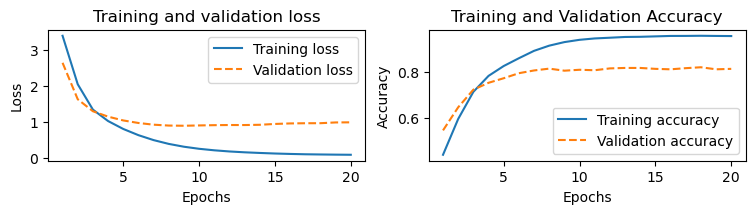

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(loss) + 1)

    fig, axs = plt.subplots(1,2, figsize=(9,1.7))
    axs[0].plot(epochs, loss, label="Training loss")
    axs[0].plot(epochs, val_loss, '--', label="Validation loss")
    axs[0].set_title("Training and validation loss", fontsize=12)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(epochs, acc, label="Training accuracy")
    axs[1].plot(epochs, val_acc, '--', label="Validation accuracy")
    axs[1].set_title("Training and Validation Accuracy")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    
    plt.show()


plot_history(history)

Programatically get the epoch with the best validation result (accuracy)

In [14]:
def best_epoch(history):
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_accuracy = history.history['val_accuracy'][best_epoch]
    print(f"Best validation accuracy: {best_accuracy} in epoch {best_epoch}")

best_epoch(history)

Best validation accuracy: 0.8220000267028809 in epoch 17


Note: In the lab notebook, it wasn't clear to me if the first item in "experiments" was the same as the last item in "visualise your results" or whether it is two separate things.

### Experiments

#### Information bottleneck

"In a stack of Dense layers like those you’ve been using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. In the previous example, you used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information."
https://deeplearningwithpython.io/chapters/chapter04_classification-and-regression/

The idea is that the number of questions a layer can ask is limited by its inputs. l2 can ask questions in 8d space if l1 has 8 units (ie can make cuts in 8d space).

If we have 1000 inputs and 100 classes, but at some point in the sequence, collapse to 2d space, there's no way to recover enough information to classify (unless trivial I guess).

So, to see this deliberately, we can make a model with a bottleneck.

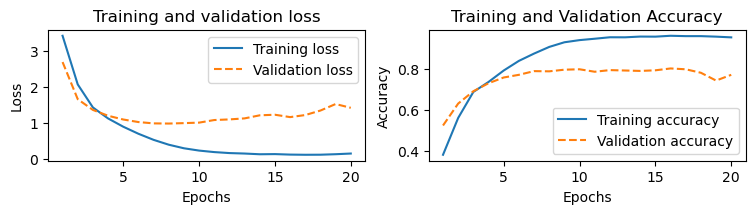

Best validation accuracy: 0.8040000200271606 in epoch 15


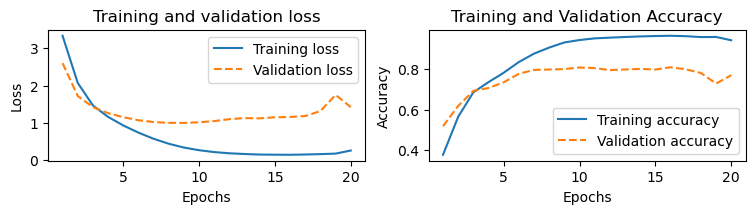

Best validation accuracy: 0.8080000281333923 in epoch 15


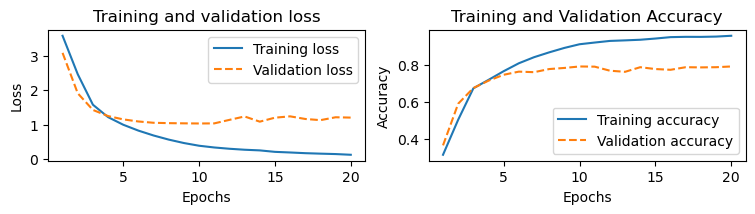

Best validation accuracy: 0.7940000295639038 in epoch 9


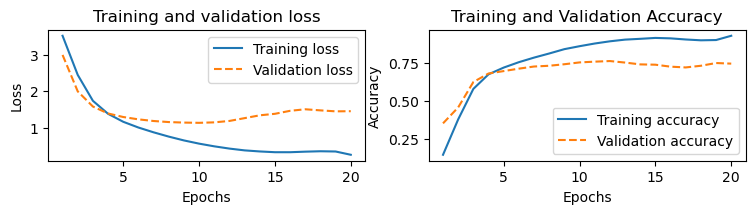

Best validation accuracy: 0.7639999985694885 in epoch 11


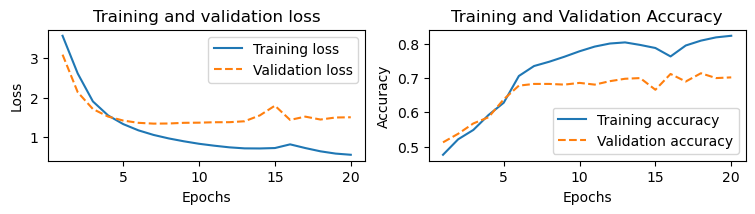

Best validation accuracy: 0.7139999866485596 in epoch 17


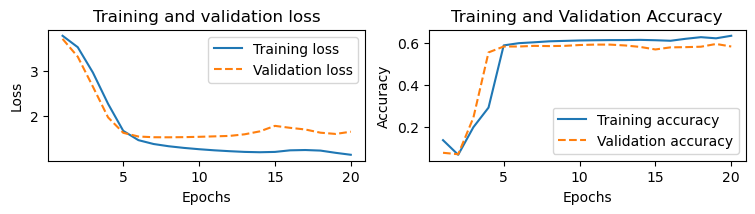

Best validation accuracy: 0.5929999947547913 in epoch 18


In [16]:
def show_bottleneck(count):
    model = keras.models.Sequential()
    model.add(keras.Input((10000,)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(count, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(46, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        partial_x_train,
        partial_y_train,
        epochs = 20,
        batch_size=512,
        validation_data=(x_val, y_val),
        verbose=0
    )

    plot_history(history)
    best_epoch(history)
   
for count in [64, 32, 16, 8, 4, 2]:
    show_bottleneck(count) 




So, for this test, accuracy drops a lot once we do 4 or 2, but stays around 95% with 8, 16, 32.

### Hyperparameter experiments

Perhaps we could show the results in a table.

Perhaps the y axis of the table is number of layers, and the x axis is units per hidden layer.

We would want to to see the best accuracy and its epoch. 

Perhaps we would want to see the charts?

In [17]:
results = {}


def run_test(num_hidden_layers, units_per_hidden_layer, optimizer='adam', plot=False):
    model = keras.models.Sequential()
    model.add(keras.Input((10000,)))

    for _ in range(num_hidden_layers):
        model.add(keras.layers.Dense(units_per_hidden_layer, activation='relu'))

    model.add(keras.layers.Dense(46, activation='softmax'))

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        partial_x_train,
        partial_y_train,
        epochs = 20,
        batch_size=512,
        validation_data=(x_val, y_val),
        verbose=0
    )

    best_epoch = np.argmax(history.history['val_accuracy'])
    best_accuracy = history.history['val_accuracy'][best_epoch]

    if(plot):
        plot_history(history)

    return (best_epoch, best_accuracy)


In [ ]:
i = 1
results = {}

units_per_hidden_layer_options = [2, 4, 6, 8, 16, 32, 64, 128]
number_of_hidden_layers_options = [1, 2, 4, 6, 8, 10]
total = len(number_of_hidden_layers_options) * len(units_per_hidden_layer_options)

# Uncomment to test fewer
# units_per_hidden_layer_options = [2, 4]
# number_of_hidden_layers_options = [1, 2]


for nhl in number_of_hidden_layers_options:
    results[nhl] = {}
    for uphl in units_per_hidden_layer_options:
        results[nhl][uphl] = run_test(nhl, uphl)
        print(f"\r[{i}/{total}] layers={nhl}, units={uphl}    ", end="")
        i += 1



[47/48] layers=10, units=128    

In [ ]:
!pip install pandas

In [20]:
import pandas as pd

# ty Claude
df = pd.DataFrame(
    {uphl: {nhl: f"{results[nhl][uphl][1] * 100:.2f}%" for nhl in results}
     for uphl in units_per_hidden_layer_options}
)
df.index.name = "layers"
df.columns.name = "units"
df



units,2,4,6,8,16,32,64,128
layers,,,,,,,,
1,55.70%,67.20%,70.20%,74.50%,80.40%,81.30%,82.30%,82.30%
2,54.40%,58.90%,69.20%,71.00%,79.90%,80.70%,81.60%,82.70%
4,48.20%,51.50%,65.30%,63.50%,74.50%,76.60%,79.10%,79.80%
6,35.40%,35.40%,59.40%,61.60%,68.70%,74.70%,77.30%,77.20%
8,35.40%,36.20%,55.40%,22.20%,66.50%,71.50%,74.10%,74.60%
10,35.40%,35.40%,35.40%,60.20%,62.20%,70.70%,70.30%,71.30%


In [27]:
best_acc = 0
smallest = 256*10
smallest_best_acc = 0
s_best_epoch = 0
s_best_nhl = 0
s_best_uphl  =0

for nhl in results:
    for uphl in results[nhl]:
        epoch, acc = results[nhl][uphl]
        if acc >= 0.80 and uphl * nhl < smallest:
            s_best_nhl, s_best_uphl, s_best_epoch = nhl, uphl, epoch
            smallest = uphl * nhl
            smallest_best_acc = acc

        if acc > best_acc:
            best_acc = acc
            best_nhl, best_uphl, best_epoch = nhl, uphl, epoch

print(f"Best accuracy of {best_acc} (epoch {best_epoch}) with {best_nhl} layers of {best_uphl} units")
print(f"Smallest network with accuracy > 0.80: {smallest_best_acc} (epoch {s_best_epoch}) with {s_best_nhl} layers of {s_best_uphl} units")

Best accuracy of 0.8270000219345093 (epoch 10) with 2 layers of 128 units
Smallest network with accuracy > 0.80: 0.8040000200271606 (epoch 18) with 1 layers of 16 units


We can also try different optimizers.

Note, in the example lab it does:

    `optimizers = [keras.optimizers.Adam, keras.optimizers.Adam]`

so it is comparing Adam with Adam, it looks like.

in the table, it might also be interesting to include training time, or training time per point of accuracy.

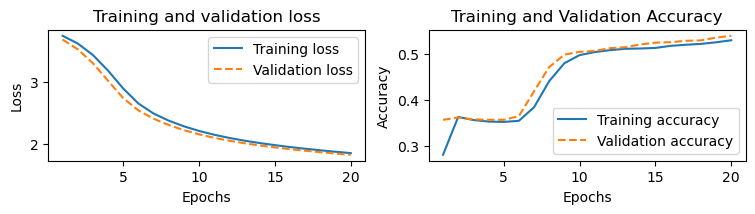

[1/3]

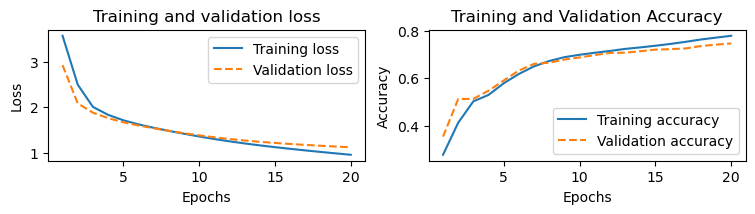

[2/3]

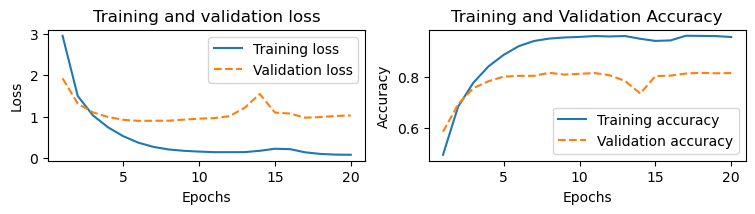

[3/3]

In [29]:

# SGD, SGD+Momentum, Adam
optimizers = {
    "SGD":          keras.optimizers.SGD(learning_rate=0.01),
    "SGD+momentum": keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    "Adam":         keras.optimizers.Adam(),
}


# i suppose ideally we would do this on all of them, but then we have to have a 3d grid
total = 3
results = {}
i = 1
for name, optimizer in optimizers.items():
    results[name] = run_test(2, 128, optimizer, plot=True)
    print(f"\r[{i}/{total}]", end='')
    i += 1


In [30]:
import pandas as pd

df = pd.DataFrame(
    {name: {"epoch": results[name][0], "accuracy": f"{results[name][1] * 100:.2f}%"}
     for name in results}
).T
df.index.name = "optimizer"
df


,epoch,accuracy
optimizer,,
SGD,19,54.00%
SGD+momentum,19,74.60%
Adam,7,81.70%


SGD gets to about 50% acc, while SGD with momentum gets to 75% and ADAM gets to 95%.

Only Adam gets to the point where it starts overtraining within 20 epochs.

## Conclusion

The best model was 7-10 epochs of hidden layers of 128 units.

In [33]:
def full_training(nhl, uphl, optimizer, epochs):
    model = keras.models.Sequential()
    model.add(keras.Input((10000,)))
    
    for _ in range(nhl):
        model.add(keras.layers.Dense(uphl, activation='relu'))
    
    model.add(keras.layers.Dense(46, activation='softmax'))
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history=model.fit(
        x_train,
        one_hot_train_labels,
        epochs=epochs,
        batch_size=512,
        validation_data = (x_test, one_hot_test_labels) # see test results as we go
    )
    plot_history(history)

    best_epoch = np.argmax(history.history['val_accuracy'])
    best_accuracy = history.history['val_accuracy'][best_epoch]

    return model, best_epoch, best_accuracy



Epoch 1/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4672 - loss: 2.7857 - val_accuracy: 0.6474 - val_loss: 1.8410
Epoch 2/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6943 - loss: 1.4322 - val_accuracy: 0.7075 - val_loss: 1.3212
Epoch 3/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7828 - loss: 0.9783 - val_accuracy: 0.7560 - val_loss: 1.1082
Epoch 4/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8519 - loss: 0.6908 - val_accuracy: 0.7734 - val_loss: 0.9870
Epoch 5/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8992 - loss: 0.4823 - val_accuracy: 0.7850 - val_loss: 0.9306
Epoch 6/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9282 - loss: 0.3378 - val_accuracy: 0.7952 - val_loss: 0.9179
Epoch 7/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9407 - loss: 0.2484 - val_accuracy: 0.7974 - val_loss: 0.9450
Epoch 8/8
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9481 - loss: 0.1989 - val_accuracy: 0.8059 - val_loss:

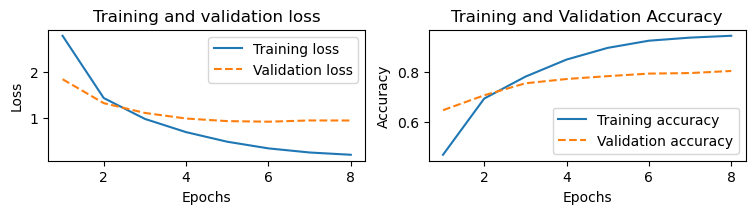

In [38]:
model, best_epoch, best_accuracy = full_training(2, 128, 'adam', 8)

In [39]:
model.evaluate(x_test, one_hot_test_labels)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8059 - loss: 0.9437


[0.9436754584312439, 0.8058770895004272]

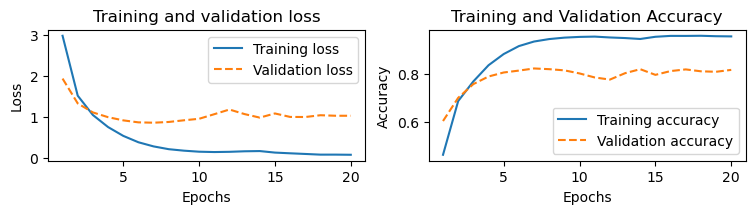

In [40]:
# view chart for validation data
be, ba = run_test(2, 128, 'adam', plot=True)

In [41]:
print(f'Best epoch: {be}')

Best epoch: 6


It doesn't look like the best epoch is 15 tho.

(issue ended up being that i was computing best epoch based on training accuracy, not validation accuracy)

redid it and looks fine now.